# Jacobian Determinant

$$
J = \text{det}(\mathbf{J}),
$$
where $\mathbf{J}$ is the Jacobian matrix of partial derivatives. Each element of $\mathbf{J}$, denoted as $J_{ij}$, represents the partial derivative of the transformed variable $x'_i$ with respect to the original variable $x_j$. For an $n$-dimensional transformation from variables $\mathbf{x}$ to $\mathbf{x'}$ using a function $\mathbf{f}(\mathbf{x}) = \mathbf{x'}$, the Jacobian matrix is defined as:

$$
\mathbf{J} = \left[\begin{array}{ccc}
\frac{\partial x'_1}{\partial x_1} & \cdots & \frac{\partial x'_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial x'_n}{\partial x_1} & \cdots & \frac{\partial x'_n}{\partial x_n}
\end{array}\right].
$$

In [1]:
import numpy as np
from pobs.utils import get_param_from_json, save_json, load_json, plot
from pobs.modelgenerator import ModelGenerator
from ler.utils import append_json
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import corner
import matplotlib.lines as mlines
import h5py 
import pandas as pd
import json
import pickle

Setting multiprocessing start method to 'fork'


## Define all scaling functions

In [2]:
import scipy.stats as stats
from scipy.stats import norm

def uniform_to_gaussian(x, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Transform to U(0,1)
    U = x / abs(upper_bound - lower_bound)

    # Transform to standard normal
    Z = norm.ppf(U)

    # If you want a normal distribution with mean mu and standard deviation sigma
    X = mu + sigma * Z
    return X

def gaussian_to_uniform(X, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Reverse the normal scaling to standard normal
    Z = (X - mu) / sigma

    # Transform standard normal back to U(0,1)
    U = norm.cdf(Z)

    # Scale U(0,1) back to U(0, 0.8)
    x = abs(upper_bound - lower_bound) * U
    return x

def sine_to_gaussian(X):
    uniform = (np.cos(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_sine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    sine = np.arccos(2 * uniform - 1)  # Convert to the sine of the angle
    return sine

def cosine_to_gaussian(X):
    uniform = (np.sin(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_cosine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    cosine = np.arcsin(2 * uniform - 1)  # Convert to the cosine of the angle
    return cosine

def scale_to_range(X, min_data=None, max_data=None, min_target=0+0.0001, max_target=np.pi-0.0001):
    if min_data is None:
        min_data = np.min(X)
    if max_data is None:
        max_data = np.max(X)
    X_std = (X - min_data) / (max_data - min_data)
    X_scaled = X_std * (max_target - min_target) + min_target
    return X_scaled

def unscale_to_range(X, min_data, max_data, min_target=0+0.0001, max_target=np.pi-0.0001):
    X_scaled = (X - min_target) / (max_target - min_target)
    X_unscaled = X_scaled * (max_data - min_data) + min_data
    return X_unscaled

# for saving min max values for scaling as json
def save_min_max(data_dict, filename):
    min_max = {}
    for key, value in data_dict.items():
        min_max[key] = dict(
            min_data = np.min(value), 
            max_data = np.max(value),
        )
    save_json(filename, min_max)

In [3]:
def get_model_and_scaler(model_path, scaler_path, min_max_path=None, dir='ler_data'):
    
    with open(dir+'/'+model_path, 'rb') as f:
        dpgmm = pickle.load(f)

    with open(dir+'/'+scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    if min_max_path is not None:
        min_max = load_json(dir+'/'+min_max_path)
        return dpgmm, scaler, min_max
    else:
        return dpgmm, scaler

## Astrophysical parameter distributions

## Lensed events

* $P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L)$

In [19]:
def data_check_astro_unlensed(data_dict):

    unlensed_param = {}

    param_list = ['ra', 'dec', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'mass_1', 'mass_2', 'luminosity_distance', 'geocent_time', 'optimal_snr_net']

    len_ = len(data_dict['geocent_time'])
    idx_all = np.arange(0, len_)
    # randomize idx_all
    np.random.shuffle(idx_all)

    for key in param_list:
        try:
            # randomize the data data_dict[key]
            unlensed_param[key] = np.array(data_dict[key])[idx_all]
        except:
            print(f"data_dict should have the following keys: {param_list}")
            raise ValueError(f"{key} is not present in the data_dict")

    #########################################
    # pairing indices for the unlensed data #
    #########################################
    # how many possible combination all
    num_combinations = comb(len_, 2, exact=True)
    # Known number of combinations
    C = size if size < num_combinations else num_combinations
    len_ = (1 + np.sqrt(1 + 8 * C)) / 2
    # Define the index array
    idx_all = np.arange(0, int(len_))
    # # randomize idx_all
    # np.random.shuffle(idx_all)

    # Generate all possible two-element combinations
    combination_array = np.array(list(itertools.combinations(idx_all, 2)))
    idx1 = combination_array[:,0]
    idx2 = combination_array[:,1]

    geocent_time1 = unlensed_param['geocent_time'][idx1]
    geocent_time2 = unlensed_param['geocent_time'][idx2]
    # (geocent_time2 - geocent_time1) > 0, otherwise swap. 1 is earlier than 2
    mask = geocent_time2 <= geocent_time1  
    idx1[mask], idx2[mask] = idx2[mask], idx1[mask]

    param_list = ['mass_1','mass_2', 'ra', 'dec', 'theta_jn','dl']

    data_dict1 = {}
    data_dict2 = {}
    for key in param_list:
        # data_dict1[key] = unlensed_param[key][idx1]
        # data_dict2[key] = unlensed_param[key][idx2]
        # choose only unique values
        data_dict1[key] = np.unique(unlensed_param[key][idx1])
        data_dict2[key] = np.unique(unlensed_param[key][idx2])

    data_dict2['log10_dt_12_days'] = np.log10((unlensed_param['geocent_time'][idx2]-unlensed_param['geocent_time'][idx1])/86400.)
    data_dict2['log10_dt_12_days'] = np.unique(data_dict2['log10_dt_12_days'])


    return data_dict1, data_dict2

In [20]:
# get data for detectable events
data_dict = get_param_from_json('/Users/phurailatpamhemantakumar/phd/mypackages/pobs/pobs/data/n_lensed_detectable_bbh_po_spin.json')
lensed_param = data_check_astro_lensed(data_dict)
lensed_param.keys()

dict_keys(['mass_1', 'mass_2', 'ra', 'dec', 'theta_jn', 'dl_1', 'dl_2', 'dt_12'])

In [21]:
# using distance ratio
list3 = ['mass_1', 'mass_2', 'theta_jn', 'log10_dl_1', 'log10_dl_2', 'log10_dt_12_days']
lensed_param3 = {}
lensed_param3['mass_1'] = lensed_param['mass_1']
lensed_param3['mass_2'] = lensed_param['mass_2']
lensed_param3['theta_jn'] = lensed_param['theta_jn']
lensed_param3['dl_1'] = lensed_param['dl_1']
lensed_param3['dl_2'] = lensed_param['dl_2']
lensed_param3['dt_12'] = lensed_param['dt_12']
lensed_param3['dl_12'] = lensed_param['dl_1'] / lensed_param['dl_2']
#del lensed_param3['dl_2']

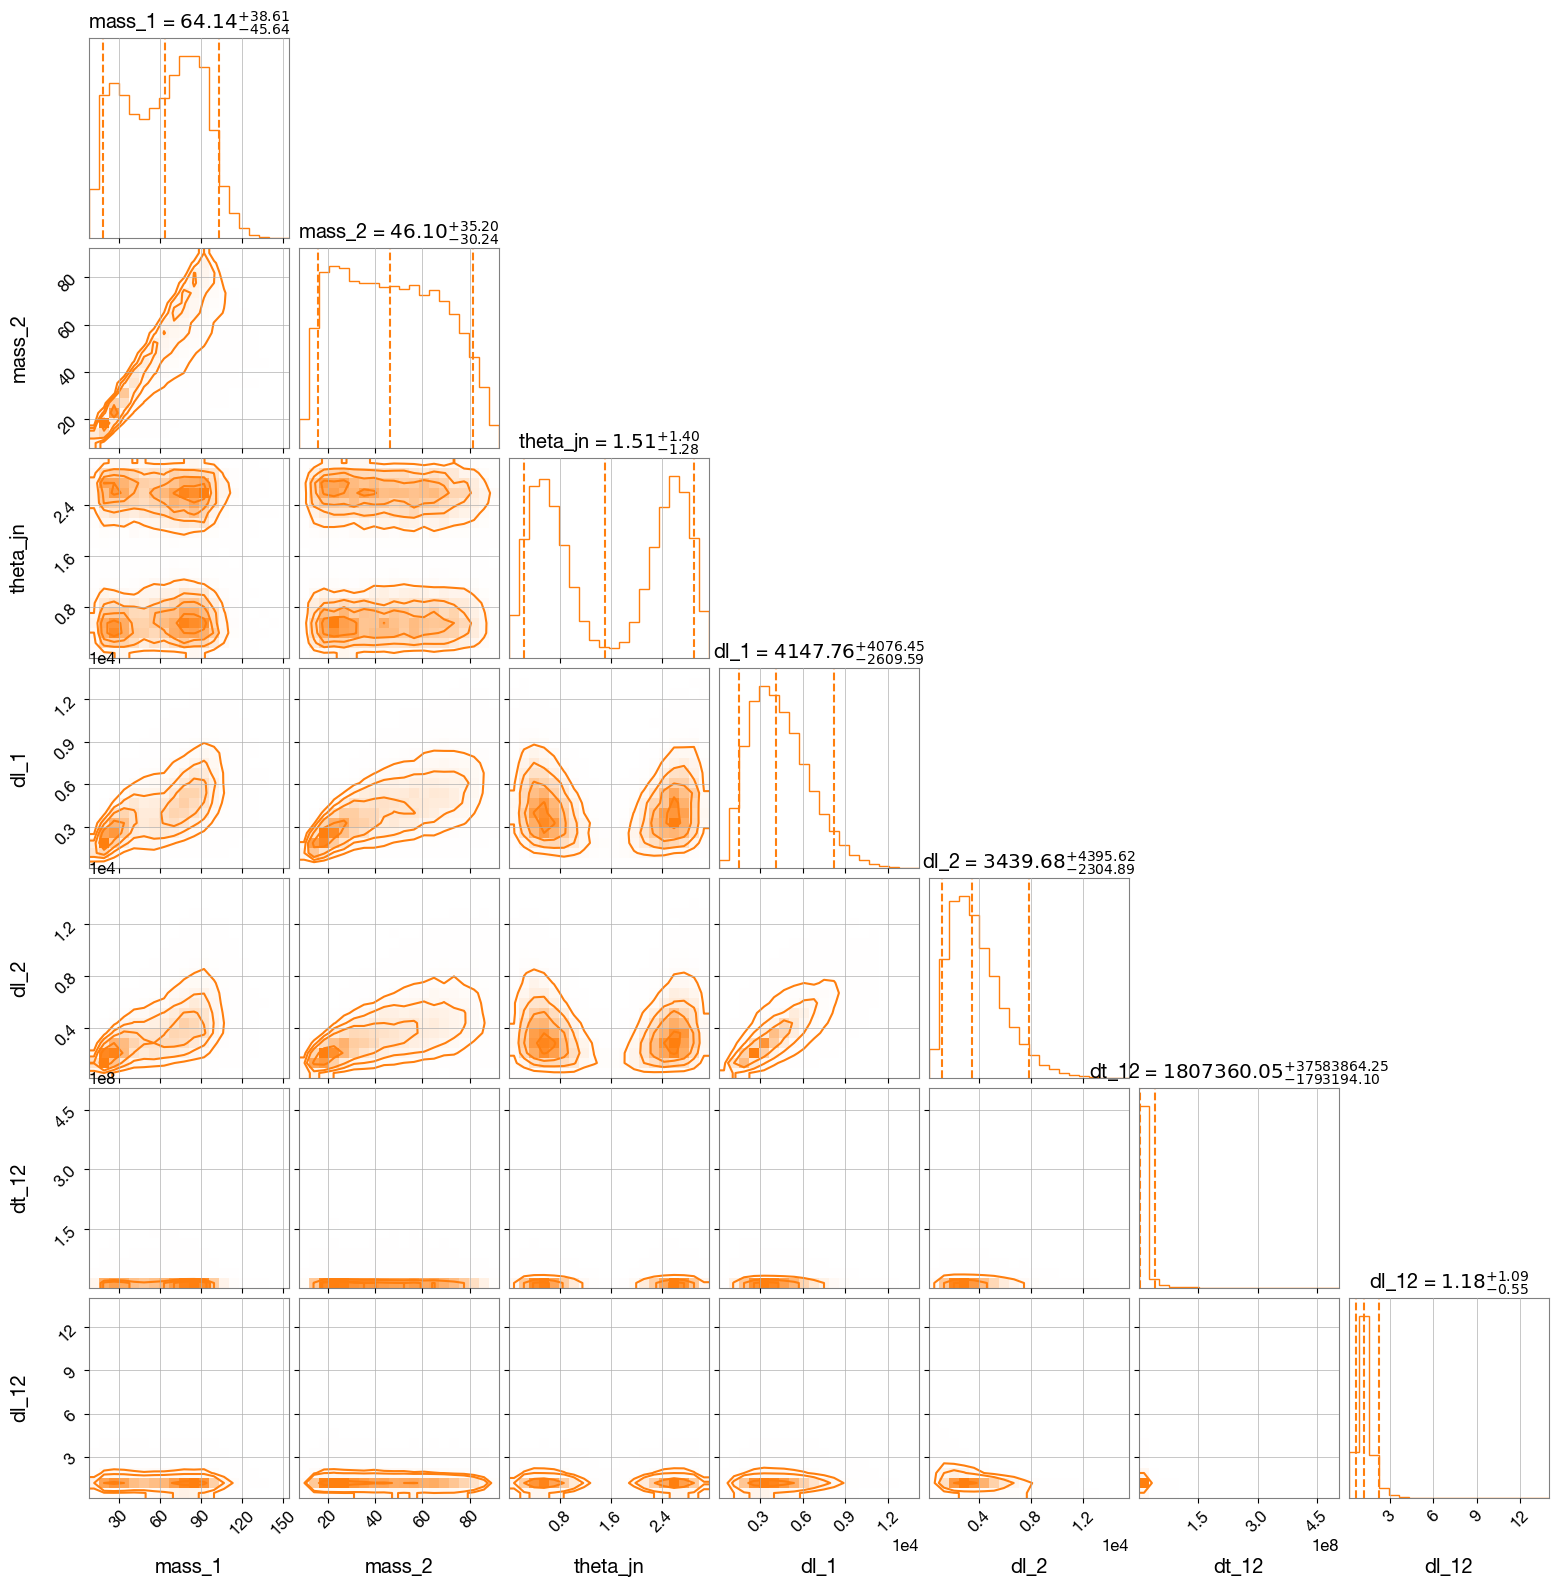

In [22]:
plot(lensed_param3)

In [ ]:
# using distance ratio
list3 = ['mass_1', 'mass_2', 'theta_jn', 'log10_dl_1', 'log10_dl_2', 'log10_dt_12_days']
lensed_param3 = {}
lensed_param3['mass_1'] = lensed_param['mass_1']
lensed_param3['mass_2'] = lensed_param['mass_2']
lensed_param3['theta_jn'] = lensed_param['theta_jn']
lensed_param3['dl_1'] = lensed_param['log10_dl_1']
lensed_param3['dl_2'] = lensed_param['log10_dl_2']
lensed_param3['dt_12_days'] = lensed_param['log10_dt_12_days']
lensed_param3['dl_12'] = np.log10((10**lensed_param['log10_dl_1']) / (10**lensed_param['log10_dl_2']))

In [33]:
list1 = ['mass_1', 'mass_2', 'theta_jn', 'log10_dl_1', 'log10_dl_2', 'log10_dt_12_days']
list2 = ['ra', 'dec']

lensed_param1 = {key: lensed_param[key] for key in list1}
lensed_param2 = {key: lensed_param[key] for key in list2}

In [34]:
test1 = ModelGenerator(
    model_name='astro_lensed', 
    data_dict=lensed_param1,
    pobs_directory="./pobs_data",
)
_,_, min_max1 = test1.get_model_scaler_minmax()
test2 = ModelGenerator(
    model_name='astro_lensed_sky', 
    data_dict=lensed_param2,
    pobs_directory="./pobs_data",
)
_,_, min_max2 = test2.get_model_scaler_minmax()
min_max1.keys(), min_max2.keys()

(dict_keys(['mass_1', 'mass_2', 'theta_jn', 'log10_dl_1', 'log10_dl_2', 'log10_dt_12_days']),
 dict_keys(['ra', 'dec']))

In [36]:
# # what original data looks like
# test1.plot(lensed_param1)
# test2.plot(lensed_param2)

### astro_lensed

In [52]:
# list of dict values
train_data_ = np.array([lensed_param1[key] for key in lensed_param1.keys()]).T
train_data_.shape

(40034, 6)

In [53]:
# scale data

# scale m1
train_data_[:,0] = scale_to_range(train_data_[:,0], min_max1['mass_1']['min_data'], min_max1['mass_1']['max_data'])
train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# scale m2
train_data_[:,1] = scale_to_range(train_data_[:,1], min_max1['mass_2']['min_data'], min_max1['mass_2']['max_data'])
train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# scale theta_jn
train_data_[:,2] = sine_to_gaussian(train_data_[:,2])

In [51]:
# # create a dictionary for the scaled data
# train_data_dict = dict(
#     mass_1 = train_data_[:,0],
#     mass_2 = train_data_[:,1],
#     theta_jn = train_data_[:,2],
#     log10_dl_1 = train_data_[:,3],
#     log10_dl_2 = train_data_[:,4],
#     log10_dt_12_days = train_data_[:,5],
# )
# test1.plot(train_data_dict)

In [54]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
# Set up the Dirichlet Process Gaussian Mixture Model
dpgmm = BayesianGaussianMixture(
    n_components=10,  # Large enough to capture complexity
    covariance_type='full',  # Each component can have its own covariance
    weight_concentration_prior=1e-1,  # Smaller values encourage more clusters
    max_iter=500,  # Increase for more convergence stability
    random_state=42
    )
# time for training, n_components=20, weight_concentration_prior=1e-2, max_iter=1000: 3m 14.6s
# time for training, n_components=10, weight_concentration_prior=1e-1, max_iter=500: 3m 14.6s
dpgmm.fit(scaled_data)

BayesianGaussianMixture(max_iter=500, n_components=10, random_state=42,
                        weight_concentration_prior=0.1)

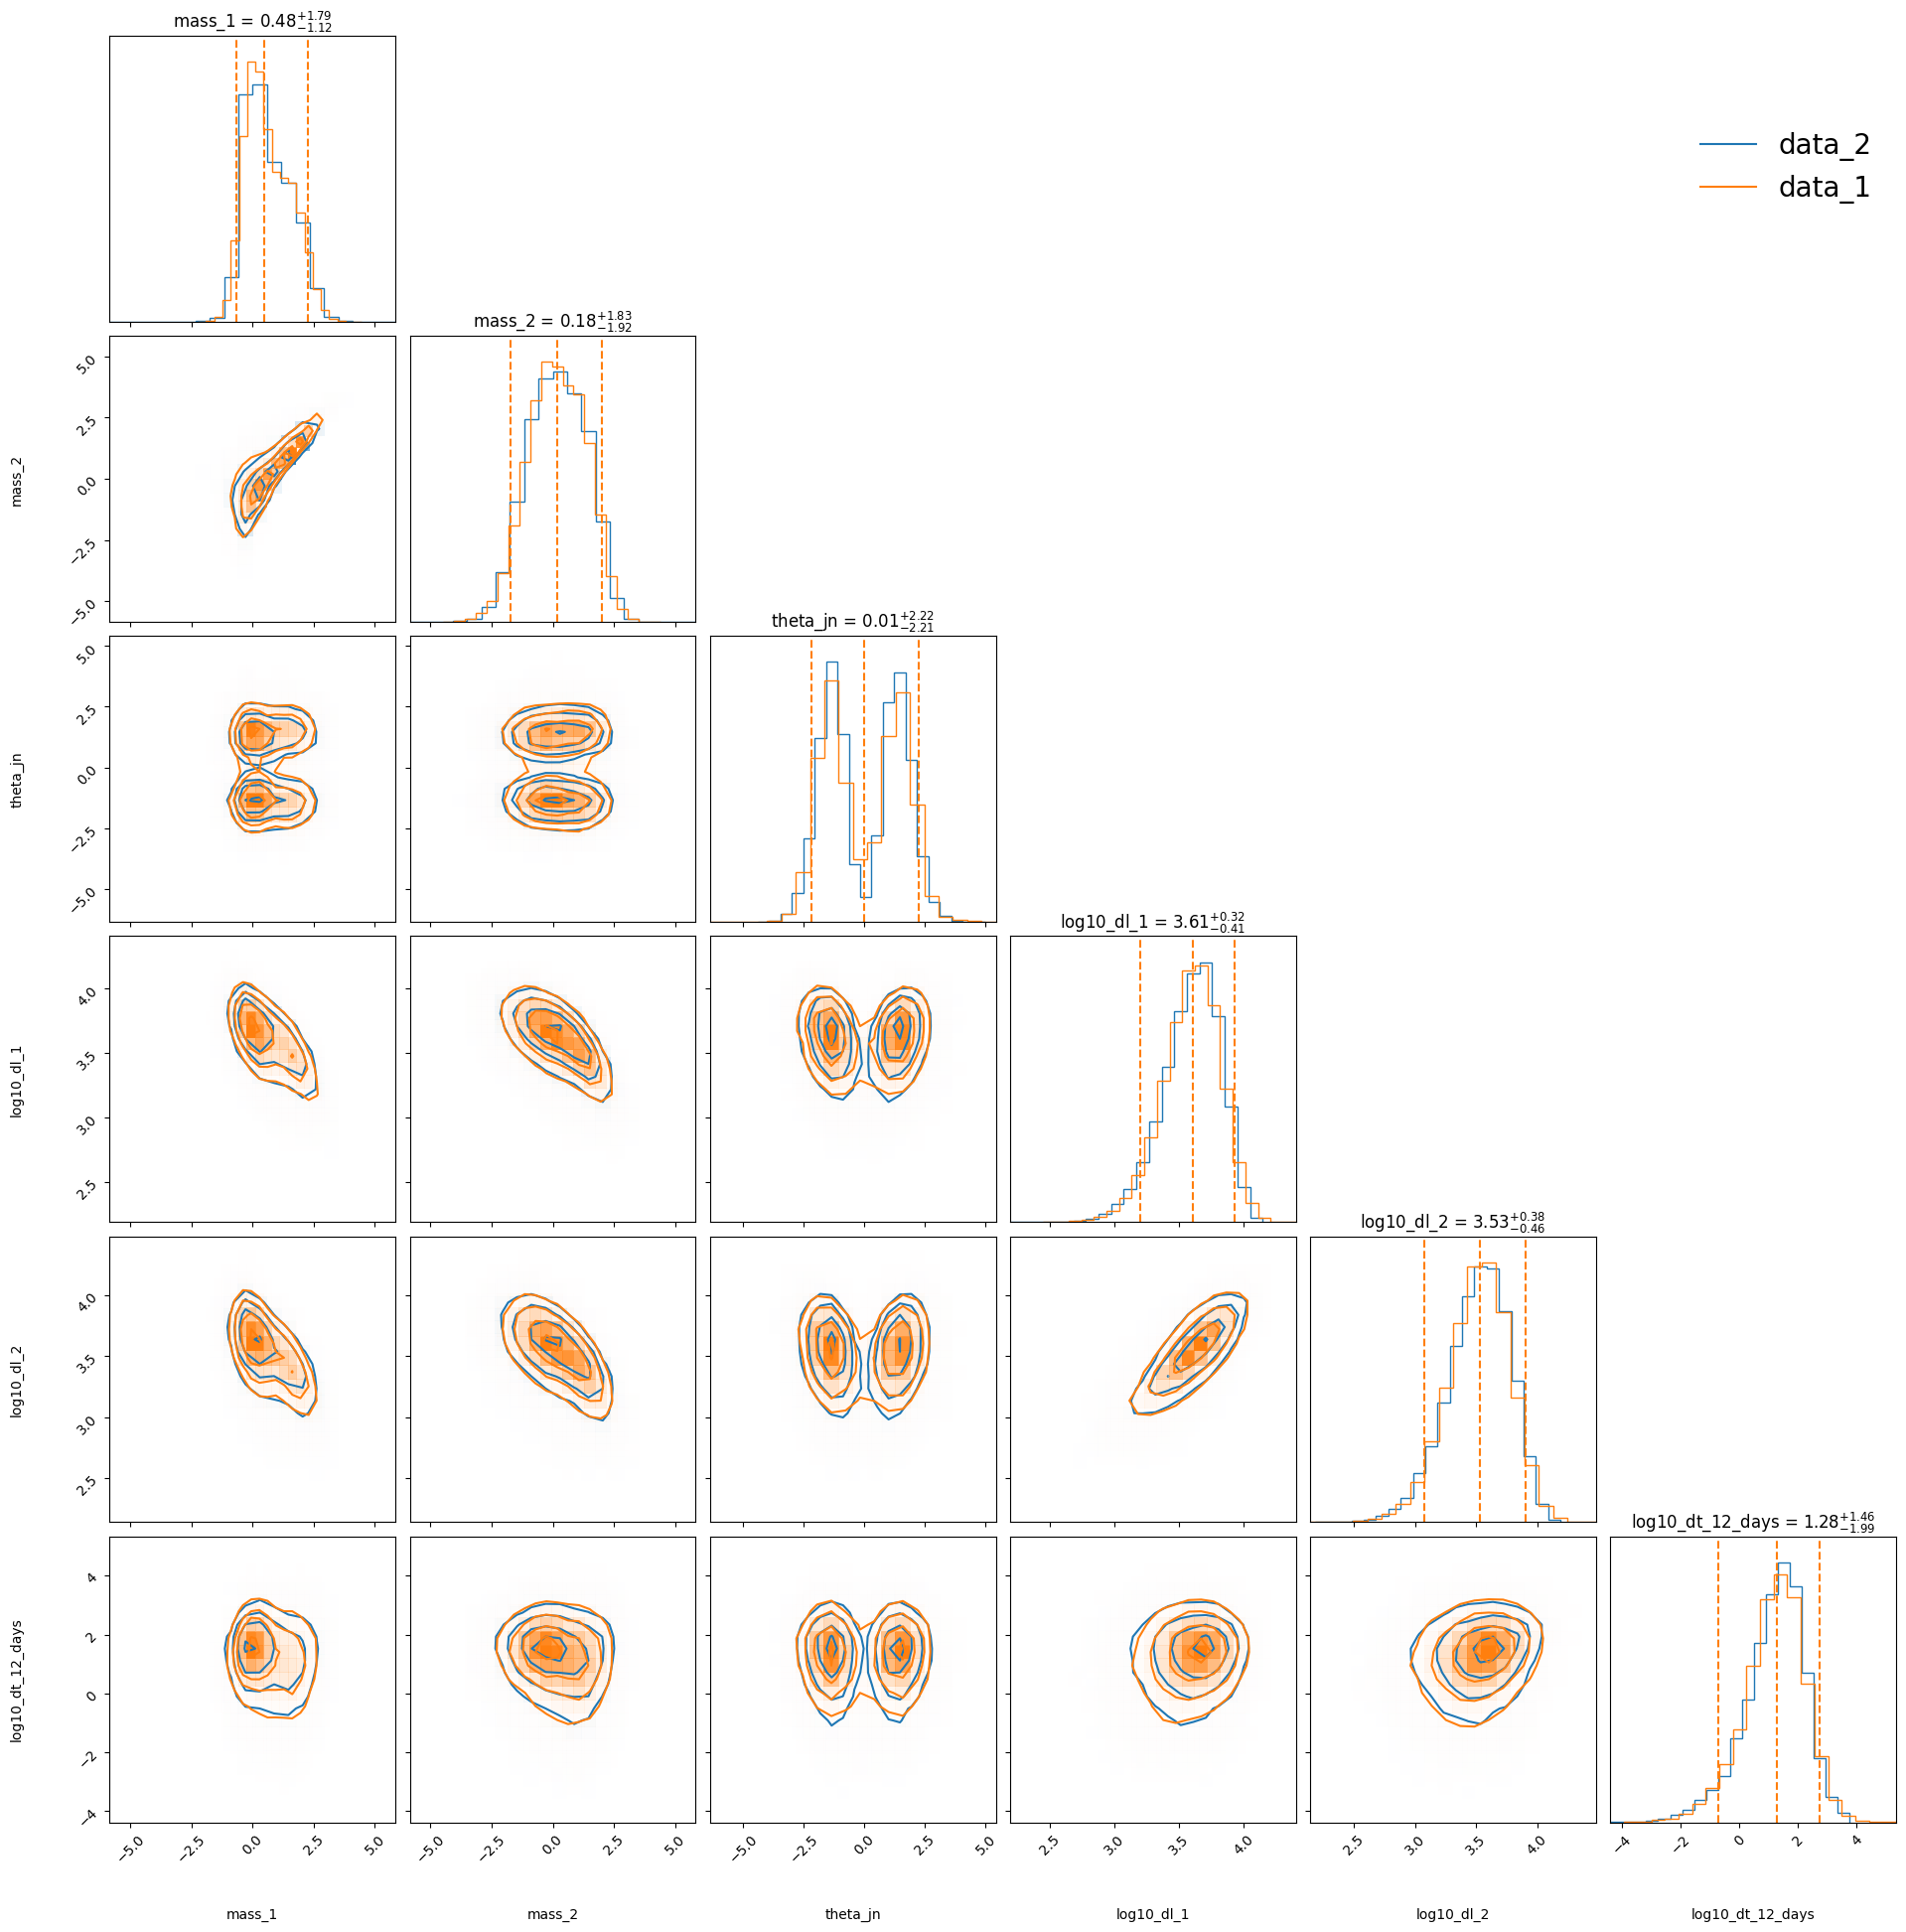

In [55]:
new_samples = dpgmm.sample(40000)[0]
# unscale data
new_samples = scaler.inverse_transform(new_samples)


new_samples_dict = dict(
    mass_1 = new_samples[:,0],
    mass_2 = new_samples[:,1],
    theta_jn = new_samples[:,2],
    log10_dl_1 = new_samples[:,3],
    log10_dl_2 = new_samples[:,4],
    log10_dt_12_days = new_samples[:,5],
)
train_data_dict = dict(
    mass_1 = train_data_[:,0],
    mass_2 = train_data_[:,1],
    theta_jn = train_data_[:,2],
    log10_dl_1 = train_data_[:,3],
    log10_dl_2 = train_data_[:,4],
    log10_dt_12_days = train_data_[:,5],
)

test1.plot(new_samples_dict, train_data_dict)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pobs.utils import save_json, load_json, data_check_astro_lensed_dpgmm, data_check_astro_lensed_sky_dpgmm, data_check_astro_unlensed_dpgmm, data_check_astro_unlensed_time_dpgmm 
from pobs.modelgenerator_dpgmm import ModelGenerator

data_dict = load_json('/Users/phurailatpamhemantakumar/phd/mypackages/pobs/pobs/data/n_unlensed_detectable_bbh_po_spin.json')
# data_dict = load_json('/Users/phurailatpamhemantakumar/phd/po-tutorial-2022/ler_data/n_unlensed_detectable_bbh_po_spin.json')
data_dict = data_check_astro_unlensed_time_dpgmm(data_dict, size=100000)

In [2]:
test = ModelGenerator(
    model_name='astro_unlensed_time', 
    create_new=True,
    n_components=20,
    weight_concentration_prior=1e-2,
    max_iter=1000,
    random_state=42,
    )

astro_unlensed is None
getting default astro_unlensed data_dict from pobs module


/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


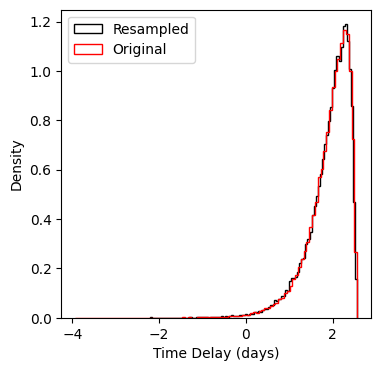

In [10]:
new_samples = test.resample(50000)

plt.figure(figsize=(4, 4))
plt.hist(new_samples['log10_dt_12_days'], bins=100, histtype='step', color='black', label='Resampled', density=True)
plt.hist(data_dict['log10_dt_12_days'], bins=100, histtype='step', color='red', label='Original', density=True)
plt.xlabel('Time Delay (days)')
plt.ylabel('Density')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

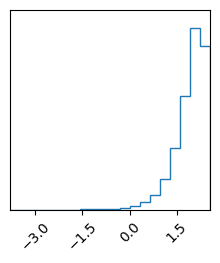

In [3]:
new_samples = test.resample(50000)
test.plot(new_samples, data_dict)

In [10]:
# from pobs.utils import save_min_max, load_json
# filename = test.meta_dict["min_max_path"]
# # min_max = save_min_max(filename, test.data_dict)
# # test.min_max = min_max
# min_max = load_json(filename)

In [9]:
# new_samples_x,_ = test.scaling(data_dict=test.data_dict, which_type="forward")
# test.plot(new_samples_x)

In [27]:
# new_samples,_ = test.scaling(data_dict=new_samples, which_type="backward")
# test.plot(new_samples)

In [3]:
data = test.model.sample(40000)[0]
new_samples = {}
j=0
for key in test.meta_dict['scaling_param'].keys():
    new_samples[key] = np.array(data[:,j])
    j+=1
new_samples, _ = test.scaling(data_list=data, which_type="backward")

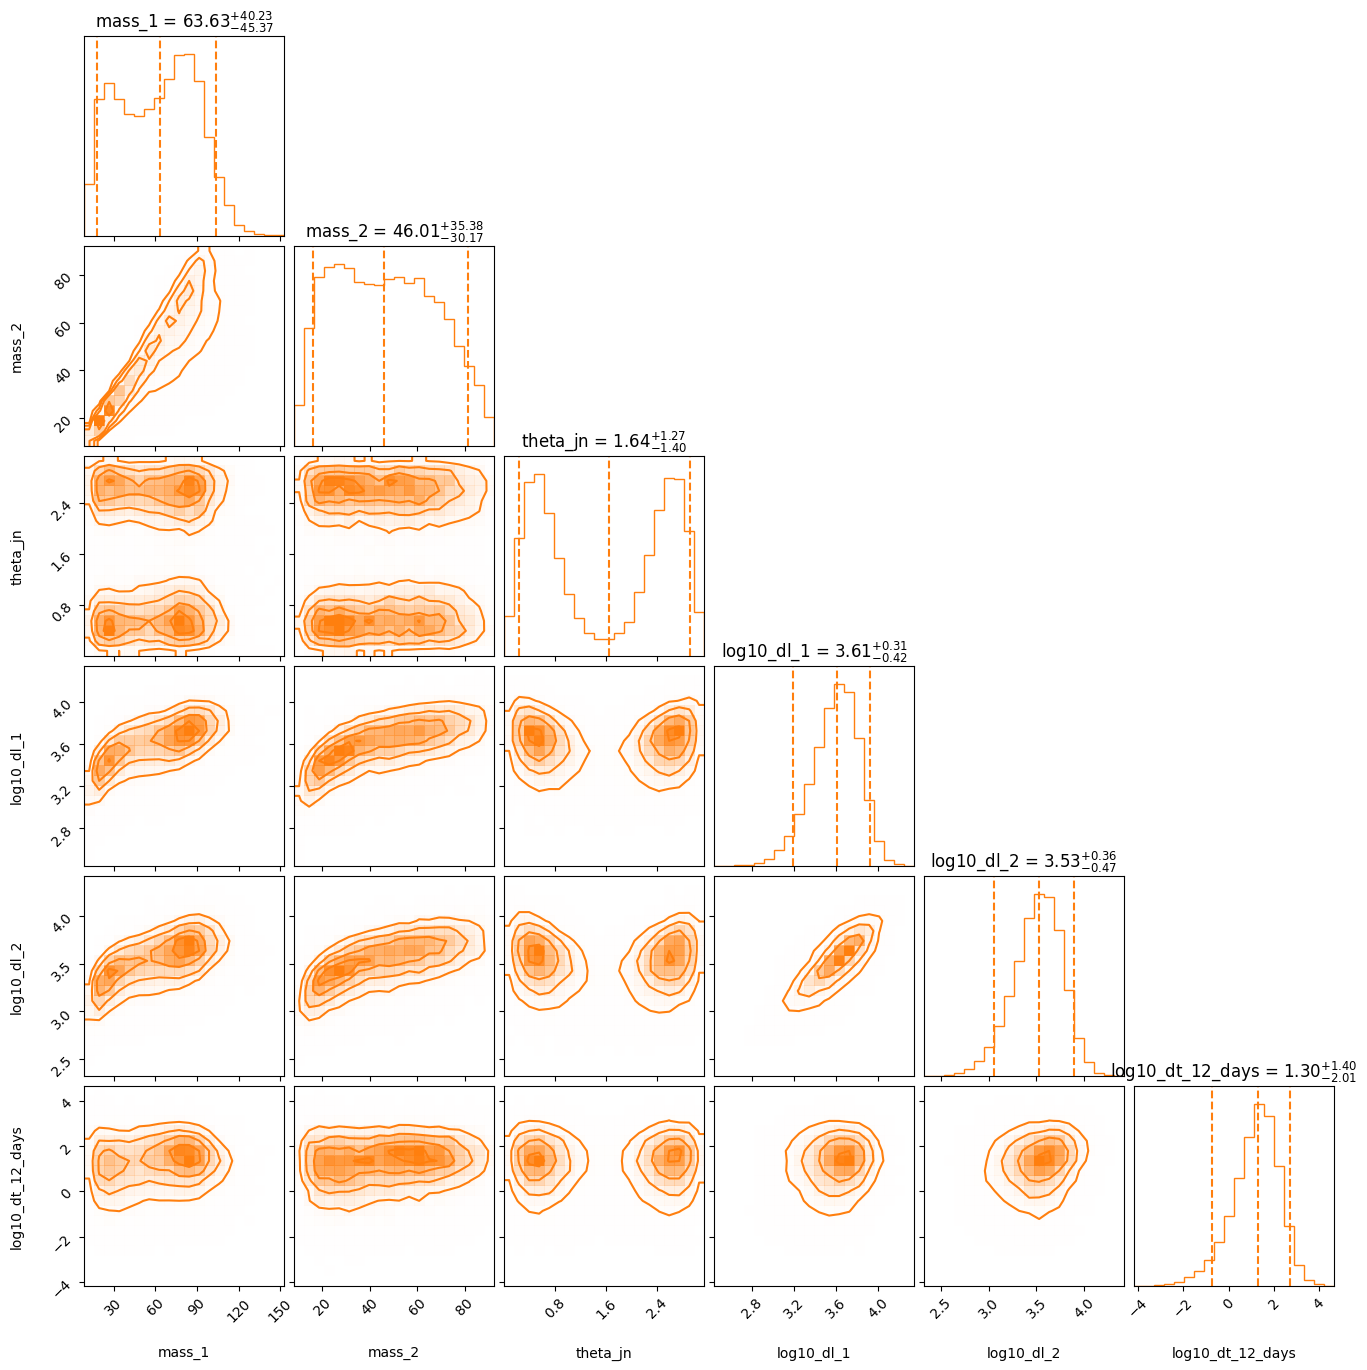

In [4]:
test.plot(new_samples)